In [1]:
import os
import scipy.io
import pandas as pd
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from bibliotheque_ensta import *
print('ok')

ok


In [2]:
nom_dir = "/home/datawork-osmose/dataset/ml18_294b/analysis/getFeatures/8000/1H/"

os.chdir(nom_dir)
os.getcwd()

ll = nom_dir + "complete.pkl"

[total_welch, total_tol, aux, total_time, frequencies] = pickle.load(open(ll, 'rb'))

In [3]:
X = prepa_total_tol_time(total_tol, total_time)

In [4]:
nom_dir = "/home4/datahome/rbessoua/Guinet/ml18_294b/"

os.chdir(nom_dir)
os.getcwd()

target = pd.read_csv(nom_dir+"ml18_294b_y_final.csv")
target.head()

,year,month,day,hour,u10,v10,tp
0,2018,10,21,7,2.246096,5.146330,0.000003
1,2018,10,21,8,2.523279,4.524844,0.000008
2,2018,10,21,9,2.698102,4.492690,0.000024
3,2018,10,21,10,2.850121,4.201290,0.000009
4,2018,10,21,11,3.491645,3.174357,0.000002


In [5]:
data = target.merge(X, on = ['year', 'month', 'day', 'hour'])

data['w10']=data['u10']
for i in range(len(data)):
    data['w10'].loc[i] = root_mean_squarred(data['u10'].iloc[i], data['v10'].iloc[i])

/home4/datahome/rbessoua/conda-env/dl-env/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='w10', ylabel='Count'>

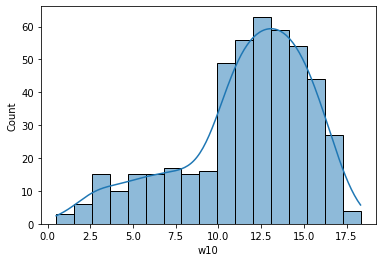

In [6]:
sns.histplot(data['w10'], kde=True)

In [7]:
X = data.drop(['u10', 'v10', 'w10', 'tp'], axis=1)
Y = data['w10']

## Random Forest Transfer (SPMAuralA)

In [8]:
!pip install joblib

from joblib import dump, load
import os
nom_dir = "/home4/datahome/rbessoua/modeles/"

os.chdir(nom_dir)

rf = load('rfv_SPMAuralA.joblib') 

  Using cached https://files.pythonhosted.org/packages/55/85/70c6602b078bd9e6f3da4f467047e906525c355a4dacd4f71b97a35d9897/joblib-1.0.1-py3-none-any.whl
Exception:
Traceback (most recent call last):
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/appli/conda-env/jupyterhub/lib/python3.6/site-packages/pip/wheel.py"

In [9]:
pred_rf = rf.predict(X)

histo = pd.DataFrame(data={'pred':pred_rf, 'target':data['w10']})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
sns.lineplot(data = histo)

ValueError: X has 40 features, but DecisionTreeRegressor is expecting 46 features as input.

## Neural network (SPMAuralA)

In [ ]:
from keras.models import load_model

nom_dir = "/home4/datahome/rbessoua/modeles/"

os.chdir(nom_dir)
os.getcwd()

model = load_model('nnv_spmaurala.h5')

In [ ]:
X_dl = X.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn = model.predict(X_dl).reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn, 'target':data['w10']})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
sns.lineplot(data = histo)

In [ ]:
print(f"The MSE is : {np.mean((data['w10'] - pred_nn)**2)}")

## Amelioration

In [ ]:
rf = load('rfclassiv_SPMAuralA.joblib') 
model_faible = load_model('nnvf_spmaurala.h5')
model_fort = load_model('nnvfort_spmaurala.h5')

In [ ]:
y_pred_classi = rf.predict(X)

Y_faible = data['w10'][(y_pred_classi == 0)]    
X_faible = X[(y_pred_classi == 0)]

Y_fort = data['w10'][(y_pred_classi == 1)]    
X_fort = X[(y_pred_classi == 1)]

idx_faible = np.where(y_pred_classi==0)
idx_fort = np.where(y_pred_classi==1)

sns.histplot(Y_faible)

In [ ]:
pred_nn_faible = model_faible.predict(X_faible)
pred_nn_fort = model_fort.predict(X_fort)

In [ ]:
res=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res[j] = pred_nn_faible[i]
for i, j in enumerate(idx_fort[0]):
    res[j] = pred_nn_fort[i]

histo = pd.DataFrame(data={'pred':res, 'target':data['w10']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
#plt.savefig(path+'70_amelioration_nn_pred_finale.png')